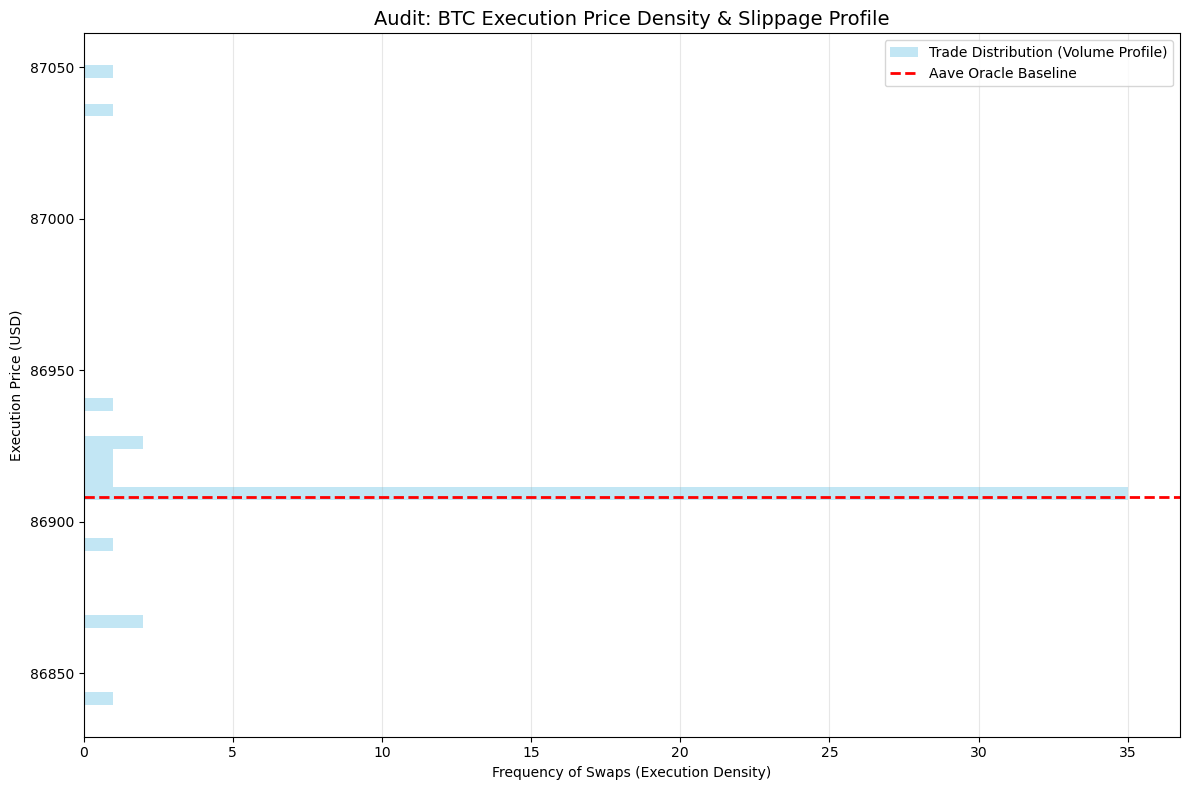

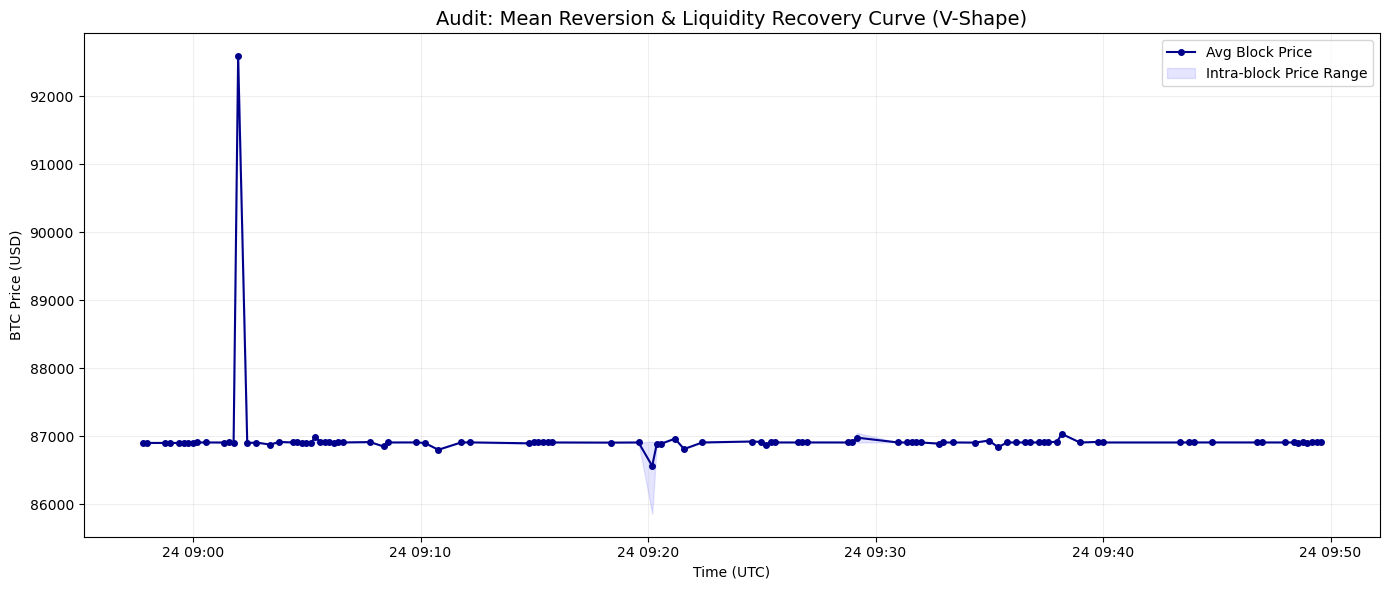

Audit processing complete.
Total DEX transactions analyzed: 47
Total Blockchain blocks audited: 100


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load Audit Data Sources ---
# Updated file paths to match the new naming convention
file_raw_trades = '01_raw_dex_trades.csv' 
file_block_agg = '02_block_aggregation.csv'

df_raw = pd.read_csv(file_raw_trades)
df_blocks = pd.read_csv(file_block_agg)

# --- 2. Robust Timestamp Normalization ---
# Ensures cross-compatibility between ISO and truncated Excel formats
def parse_normalized_time(time_str):
    time_str = str(time_str).strip()
    if '2025' in time_str:
        return time_str
    if len(time_str.split(':')) == 2:
        return f"2025-12-24 09:{time_str}"
    elif len(time_str.split(':')) == 3:
        return f"2025-12-24 {time_str}"
    return time_str

# Apply normalization to uppercase column headers
df_blocks['BLOCK_TIMESTAMP'] = pd.to_datetime(df_blocks['BLOCK_TIMESTAMP'].apply(parse_normalized_time))
df_raw['BLOCK_TIMESTAMP'] = pd.to_datetime(df_raw['BLOCK_TIMESTAMP'].apply(parse_normalized_time))

# Sort chronologically by blockchain height
df_blocks = df_blocks.sort_values('BLOCK_NUMBER')
df_raw = df_raw.dropna(subset=['BTC_SPOT_PRICE_USD']).sort_values('BLOCK_NUMBER')

# --- 3. Visualization: Execution Slippage & Volume Profile ---
# This audit identifies where trade execution deviated most from the Oracle baseline.
ORACLE_PRICE = 86908.0

plt.figure(figsize=(12, 8))

# Create a horizontal violin/distribution effect using a histogram for the price profile
plt.hist(df_raw['BTC_SPOT_PRICE_USD'], bins=50, orientation='horizontal', 
         color='skyblue', alpha=0.5, label='Trade Distribution (Volume Profile)')

plt.axhline(y=ORACLE_PRICE, color='red', linestyle='--', linewidth=2, label='Aave Oracle Baseline')

plt.title('Audit: BTC Execution Price Density & Slippage Profile', fontsize=14)
plt.ylabel('Execution Price (USD)')
plt.xlabel('Frequency of Swaps (Execution Density)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4. Visualization: Market Recovery Curve (V-Shape Analysis) ---
# Purpose: Measure the speed of Mean Reversion after the liquidity shock.
plt.figure(figsize=(14, 6))

# Plot the average price trend
plt.plot(df_blocks['BLOCK_TIMESTAMP'], df_blocks['AVG_PRICE'], 
         marker='o', markersize=4, label='Avg Block Price', color='darkblue')

# Shadow represent the intra-block slippage (Max to Min)
plt.fill_between(df_blocks['BLOCK_TIMESTAMP'], df_blocks['MIN_PRICE'], df_blocks['MAX_PRICE'], 
                 color='blue', alpha=0.1, label='Intra-block Price Range')

plt.title('Audit: Mean Reversion & Liquidity Recovery Curve (V-Shape)', fontsize=14)
plt.xlabel('Time (UTC)')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# --- 5. Export Summary ---
print("Audit processing complete.")
print(f"Total DEX transactions analyzed: {len(df_raw)}")
print(f"Total Blockchain blocks audited: {len(df_blocks)}")